In [1]:
import MySQLdb
from pymongo import MongoClient
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import sys

mongodb_db_name = "keyword"
mongodb_collection_name = "apple_news_test"
mongodb_ip = "127.0.0.1"

mariadb_db_name = "news_testdb"
mariadb_db_table = "test_news"

conn = MySQLdb.connect(host="127.0.0.1", user="root",passwd="mysql", db=mariadb_db_name, charset="utf8")
cursor = conn.cursor()

sql_command = "select create_time,tag,title_keyword_1,title_keyword_2,title_keyword_3,keyword_1,keyword_2,keyword_3," \
              "keyword_4,keyword_5,views_48 from " + mariadb_db_table + \
              " where views_48 is not null and create_time > '2019-02-10'"
cursor.execute(sql_command)
sql_data = cursor.fetchall()
cursor.close()
conn.close()

print(len(sql_data))

# 關鍵字24小時 48小時 72小時 趨勢 共32個x
title = []
keywordName = "tk"
for i in range(3):
    title.append(keywordName + str(i + 1) + "_24")
    title.append(keywordName + str(i + 1) + "_72")
    title.append(keywordName + str(i + 1) + "_168")
    title.append(keywordName + str(i + 1) + "_trend")
keywordName = "ck"
for i in range(5):
    title.append(keywordName + str(i + 1) + "_24")
    title.append(keywordName + str(i + 1) + "_72")
    title.append(keywordName + str(i + 1) + "_168")
    title.append(keywordName + str(i + 1) + "_trend")
title.append("48hr_views")
title.append("tag")

df_news = pd.DataFrame(columns=title)

conn_md = MongoClient(mongodb_ip)
mdb = conn_md[mongodb_db_name]
mcollection = mdb[mongodb_collection_name]

count = 0
for single_news in sql_data:
    count = count + 1
    if count % 200 == 0:
        print("已處理資料:", count)
    # 把時間拉出來
    newsCreateTime = single_news[0]
    # print(newsCreateTime)
    titleCount = 0
    dfData = {}
    for keywordPos in range(2, 10):
        # views = [[0],[0],[0],[0],[0],[0],[0]]
        views = [0,0,0,0,0,0,0]
        m_data = mcollection.find({"keyword": single_news[keywordPos]})[0]
        # print(m_data)
        for viewsCreateTimeStr in m_data["views"]:
            viewsCreateTime = datetime.strptime(viewsCreateTimeStr, "%Y-%m-%d %H:%M")
            dayDiff = (newsCreateTime- viewsCreateTime).total_seconds() // 86400
            dayDiff = int(dayDiff)
            if 0 <= dayDiff < 7:
                # print(viewsCreateTime, newsCreateTime, dayDiff, m_data["views"][viewsCreateTimeStr])
                views[dayDiff] = views[dayDiff] + int(m_data["views"][viewsCreateTimeStr])
        dfData[title[titleCount]] = views[0]
        titleCount = titleCount + 1
        dfData[title[titleCount]] = views[1] + views[2]
        titleCount = titleCount + 1
        dfData[title[titleCount]] = views[3] + views[4] + views[5] + views[6]
        titleCount = titleCount + 1
        # 計算斜率
        # model = LinearRegression(fit_intercept=True)
        lm = LinearRegression()
        # print(views)
        lm.fit(np.array([[0],[-1],[-2],[-3],[-4],[-5],[-6]]), np.array(views))
        # print(lm.intercept_)
        # print(lm.coef_)
        dfData[title[titleCount]] = lm.coef_[0]
        titleCount = titleCount + 1

    dfData["48hr_views"] = single_news[-1]
    dfData["tag"] = single_news[1]
    df_news = df_news.append(dfData, ignore_index=True)

print(df_news)

8825
已處理資料: 200
已處理資料: 400
已處理資料: 600
已處理資料: 800
已處理資料: 1000
已處理資料: 1200
已處理資料: 1400
已處理資料: 1600
已處理資料: 1800
已處理資料: 2000
已處理資料: 2200
已處理資料: 2400
已處理資料: 2600
已處理資料: 2800
已處理資料: 3000
已處理資料: 3200
已處理資料: 3400
已處理資料: 3600
已處理資料: 3800
已處理資料: 4000
已處理資料: 4200
已處理資料: 4400
已處理資料: 4600
已處理資料: 4800
已處理資料: 5000
已處理資料: 5200
已處理資料: 5400
已處理資料: 5600
已處理資料: 5800
已處理資料: 6000
已處理資料: 6200
已處理資料: 6400
已處理資料: 6600
已處理資料: 6800
已處理資料: 7000
已處理資料: 7200
已處理資料: 7400
已處理資料: 7600
已處理資料: 7800
已處理資料: 8000
已處理資料: 8200
已處理資料: 8400
已處理資料: 8600
已處理資料: 8800
       tk1_24   tk1_72  tk1_168      tk1_trend   tk2_24   tk2_72  tk2_168  \
0         115     6662    37803     135.142857        0        0        0   
1          98     2009     4785     -29.607143       23     1041     2784   
2           0        0        0      -0.000000        0        0      541   
3          94      333     1512     -11.142857        0        0        0   
4      247751   254660  2344898  -59020.928571        0        0        0   
5        

In [3]:
df_news.to_pickle("keyword8_v1.pkl")

In [6]:
df_news = pd.read_pickle("keyword8_v1.pkl")

,tk1_24,tk1_72,tk1_168,tk1_trend,tk2_24,tk2_72,tk2_168,tk2_trend,tk3_24,tk3_72,...,ck4_24,ck4_72,ck4_168,ck4_trend,ck5_24,ck5_72,ck5_168,ck5_trend,48hr_views,tag
0,115,6662,37803,135.142857,0,0,0,-0.000000,0,0,...,47604,13398,89614,1312.964286,123707,250229,1664707,-60774.250000,54218,娛樂
1,98,2009,4785,-29.607143,23,1041,2784,-37.857143,0,0,...,0,0,0,-0.000000,36343,16356,122416,4098.857143,6805,娛樂
2,0,0,0,-0.000000,0,0,541,-37.285714,159,3497,...,0,0,0,-0.000000,0,0,0,-0.000000,2912,娛樂
3,94,333,1512,-11.142857,0,0,0,-0.000000,247751,254660,...,57,1622,90182,-8335.000000,10603,4468,77680,-963.821429,9427,娛樂
4,247751,254660,2344898,-59020.928571,0,0,0,-0.000000,112547,154471,...,337049,747595,170283,73449.535714,50756,149913,550682,-20490.107143,95002,娛樂
5,6764,3267,570,897.000000,0,0,0,-0.000000,16726,75899,...,0,383,103058,-6546.071429,0,0,0,-0.000000,14224,娛樂
6,247751,254660,2344898,-59020.928571,79780,0,6426,7895.571429,80510,1521,...,317676,600274,1206344,-3626.214286,0,0,0,-0.000000,27068,娛樂
7,247751,254660,2344898,-59020.928571,79780,0,24420,6142.928571,0,0,...,0,176,2414,-38.678571,0,66,1638,-46.464286,15480,娛樂
8,95,5060,10861,-7.607143,0,0,0,-0.000000,12,376,...,95,5060,10861,-7.607143,0,0,0,-0.000000,7386,娛樂
9,0,0,0,-0.000000,0,0,0,-0.000000,0,0,...,10869,1612,25906,211.357143,0,0,0,-0.000000,8343,娛樂


In [7]:
train_x = df_news.drop(["48hr_views","tag"],axis=1)
train_y = df_news["48hr_views"]

lm.fit(train_x,train_y)
print(lm.intercept_)
print(lm.coef_)

predict = lm.predict(train_x)
print("r2 Score:",r2_score(train_y,predict))


12284.367973303051
[ 0.02167883  0.02150086 -0.01607398 -0.18288775  0.00419019  0.02155303
 -0.00521488 -0.15337241  0.00129528 -0.00213387 -0.00085921  0.10221047
  0.01406079 -0.00636891  0.00358656 -0.08995183  0.01703422 -0.01254786
  0.00470221  0.02736111  0.0015038  -0.00742516  0.00818928  0.14133924
  0.00688376  0.00310969  0.00250927 -0.02138274  0.01711667 -0.00287866
  0.00444997 -0.05703996]
r2 Score: 0.041618445345250055


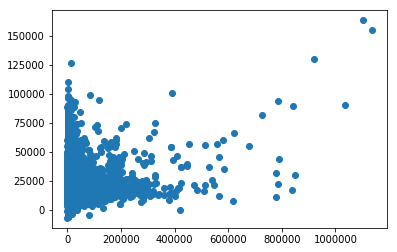

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(train_y, predict)
plt.show()

In [9]:
kw_title = list(df_news.columns)
kw_title = [e for e in kw_title if e not in ["tk1_trend","tk2_trend","tk3_trend","ck1_trend","ck2_trend","ck3_trend","ck4_trend","ck5_trend","tag"]]

['tk1_24',
 'tk1_72',
 'tk1_168',
 'tk2_24',
 'tk2_72',
 'tk2_168',
 'tk3_24',
 'tk3_72',
 'tk3_168',
 'ck1_24',
 'ck1_72',
 'ck1_168',
 'ck2_24',
 'ck2_72',
 'ck2_168',
 'ck3_24',
 'ck3_72',
 'ck3_168',
 'ck4_24',
 'ck4_72',
 'ck4_168',
 'ck5_24',
 'ck5_72',
 'ck5_168',
 '48hr_views']

In [10]:
import math
# df_news

df_news_notag = df_news.drop(["tag"],axis=1)
df_news_notag[kw_title] =df_news_notag[kw_title].applymap(lambda x: math.log10(x+1))
# df_news_notag_kwc = df_news_notag[kw_title].applymap(lambda x: x+1)
# df_news_notag_kwc
# df_news_notag_log[kw_title] = df_news_notag[kw_title].applymap(lambda x: math.log10(x+1))
# df_news_notag_log

In [ ]:
df_news_notag

In [11]:
def trend_log(x):
    if abs(x) <= 1:
        return 0
    elif x < 1:
        return math.log10(-1*x) * -1
    else:
        return math.log10(x)
    
trend_title = ["tk1_trend","tk2_trend","tk3_trend","ck1_trend","ck2_trend","ck3_trend","ck4_trend","ck5_trend"]
df_news_notag[trend_title] = df_news_notag[trend_title].applymap(trend_log)

In [12]:
train_x = df_news_notag.drop(["48hr_views"],axis=1)
train_y = df_news_notag["48hr_views"]

lm.fit(train_x,train_y)
print(lm.intercept_)
print(lm.coef_)

predict = lm.predict(train_x)
print("r2 Score:",r2_score(train_y,predict))

3.6657563989006956
[-5.79810903e-03  4.68066413e-04  5.77820438e-03  1.92310614e-03
  8.09119723e-03 -1.19471831e-02  4.97640302e-03  4.43202608e-03
  2.64951808e-04  2.08277463e-05  1.63071787e-03  1.60062099e-03
  7.61049796e-03 -8.74401069e-03 -4.08842950e-03 -7.36007562e-04
  5.61297933e-03 -5.35620694e-03  2.88858602e-03  2.57422603e-03
  4.52360326e-03  1.02430707e-03  1.00471944e-02 -1.21326817e-03
 -6.33399413e-03  2.10909555e-03  1.11469454e-02  4.25307406e-03
  2.20646405e-03  9.11194190e-03 -2.55787430e-03  1.00475380e-03]
r2 Score: 0.008879288464961221


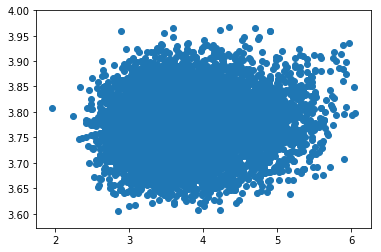

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(train_y, predict)
plt.show()

In [ ]:
import seaborn as sns
plt.figure(figsize=(28,20))
plt.title("heatmap",y = 1.05,size = 30)
sns.heatmap(df_news.drop(["tag"],axis=1).astype(float).corr(),cmap = "BrBG",linewidths=0.1,square=True, linecolor="white",annot=True)

In [ ]:
df_news.to_pickle("df_news_v1_8keyword.pkl")